In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
import numpy as np
from pathlib import Path
from itertools import product as myzip

In [3]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [4]:
def format_fn(path):
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [5]:
for dataset in datasets:
    x_paths = glob.glob(my_path + dataset + '\*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '\*.png')
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

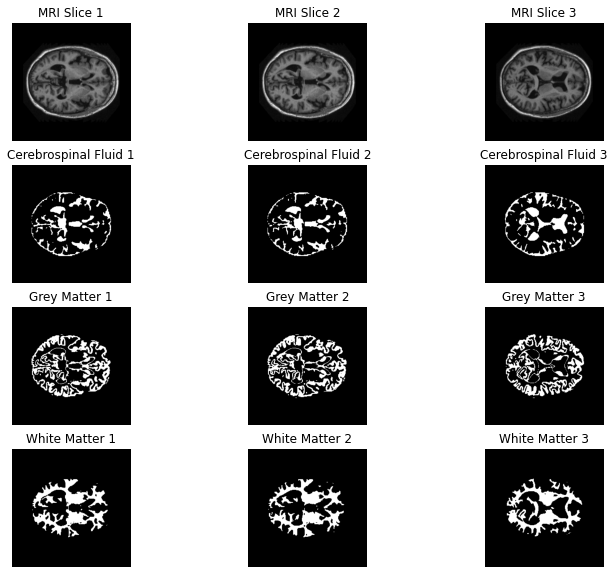

In [6]:
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
x_sample = tf.reshape(x_sample, [3, 256, 256])
y_sample = tf.reshape(y_sample, [3, 256, 256, 4])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

In [50]:
class My_Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel=3, dropout=.3):
        super(My_Conv2D, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, kernel, activation='relu', padding='same')
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        
    def call(self, x):
        x = self.conv2d_1(x)
        x = self.dropout_1(x)
        
        return x

class Downshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Downshift, self).__init__()
        self.conv2d_1 = My_Conv2D(filters)
        self.conv2d_2 = My_Conv2D(filters)
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(padding='same')
        
    def call(self, x):
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.maxpool_1(x)
        
        return x
    
class Upshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Upshift, self).__init__()
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = My_Conv2D(filters)
        self.concatenate_1 = tf.keras.layers.Concatenate()
        self.conv2d_2 = My_Conv2D(filters)
        self.conv2d_3 = My_Conv2D(filters)
        
    def call(self, x, concatenate):
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1([concatenate, x])
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        
        return x

In [51]:
class My_Simple_Model(tf.keras.Model):
    def __init__(self):
        super(My_Simple_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        
        self.downshift_1 = Downshift(40)
        self.upshift_1 = Upshift(40)
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='sigmoid', padding='same')
        
    def call(self, x_0, training=False):
        x_1 = self.input_1(x_0)
        
        x_2 = self.downshift_1(x_1)
        x_3 = self.upshift_1(x_2, x_1)
        
        x_4 = self.output_1(x_3)
        
        return x_4

In [52]:
simple_model = My_Simple_Model()

my_opt = adam(lr=3*10**-3)

simple_model.compile(optimizer=my_opt, 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

simple_model.build(input_shape=(None, 256, 256, 1))

simple_model.summary()

Model: "my__simple__model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [None]                    0         
_________________________________________________________________
downshift_10 (Downshift)     multiple                  14840     
_________________________________________________________________
upshift_5 (Upshift)          multiple                  43680     
_________________________________________________________________
conv2d_45 (Conv2D)           multiple                  164       
Total params: 58,684
Trainable params: 58,684
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = simple_model.fit(data_dict['train'].batch(30), epochs=3,
                    validation_data=data_dict['validate'].batch(30), verbose=1)

Train for 323 steps, validate for 38 steps
Epoch 1/3
323/323 [==============================] - 309s 956ms/step - loss: 0.8621 - mean_io_u_5: 0.7257 - val_loss: 0.8375 - val_mean_io_u_5: 0.4842
Epoch 2/3
323/323 [==============================] - 298s 922ms/step - loss: 0.8002 - mean_io_u_5: 0.8221 - val_loss: 0.9383 - val_mean_io_u_5: 0.5028
Epoch 3/3
323/323 [==============================] - 213s 660ms/step - loss: 0.7944 - mean_io_u_5: 0.8610 - val_loss: 0.8107 - val_mean_io_u_5: 0.8082


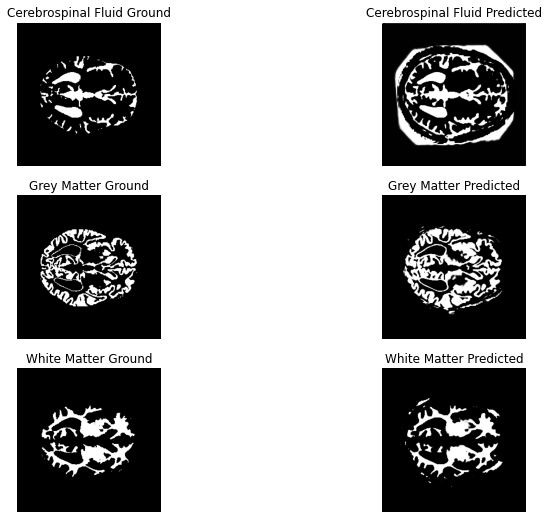

In [54]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = simple_model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

In [ ]:
class My_Larger_Model(tf.keras.Model):
    def __init__(self):
        super(My_Larger_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        
        self.downshift_1 = Downshift(64)
        self.downshift_2 = Downshift(128)
        self.downshift_3 = Downshift(256)
        
        self.deepconv2d_1 = My_Conv2D(512)
        self.deepconv2d_2 = My_Conv2D(512)
        
        self.upshift_1 = Upshift(256)
        self.upshift_2 = Upshift(128)
        self.upshift_3 = Upshift(64)
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='sigmoid', padding='same')
        
    def call(self, x_0, training=False):
        x_1 = self.input_1(x_0)
        
        x_2 = self.downshift_1(x_1)
        x_3 = self.downshift_2(x_2)
        x_4 = self.downshift_3(x_3)
        
        x_5 = self.deepconv2d_1(x_4)
        x_6 = self.deepconv2d_2(x_5)
        
        x_7 = self.upshift_1(x_6, x_4)
        x_8 = self.upshift_2(x_7, x_3)
        x_9 = self.upshift_3(x_8, x_2)
        

        x_10 = self.output_1(x_9)
        
        return x_10